<a href="https://colab.research.google.com/github/sankethsolo/kannada-MNIST/blob/master/kannada_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
Dig_MNIST = pd.read_csv("drive/My Drive/Dig-MNIST.csv")
train = pd.read_csv("drive/My Drive/train.csv")

In [0]:
# Split the data
x = train.iloc[:,1:].values
y = train.iloc[:,0].values
y[:10]

x_dig = Dig_MNIST.drop('label', axis=1).iloc[:,:].values
y_dig = Dig_MNIST.label


In [5]:
x.shape

(60000, 784)

In [0]:
# Reshape the data
x = x.reshape(x.shape[0], 28, 28, 1)
y = to_categorical(y, 10)
x_dig = x_dig.reshape(x_dig.shape[0], 28, 28, 1)


In [0]:
# Split the data between train and test
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.10, random_state=42) 

In [0]:
# Artificially increase training set
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=10,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   shear_range=0.1,
                                   zoom_range=0.25,
                                   horizontal_flip=False)

valid_datagen = ImageDataGenerator(rescale=1./255.)

In [9]:
batch_size = 1024
num_classes = 10
epochs = 50
learning_rate = 0.001
model_name = 'k-mnist_trained_model.h5'

model = Sequential()

model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.summary()

optimizer = RMSprop(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)       

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=200,
                                            verbose=1,
                                            factor=0.2)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=50,
                              epochs=epochs,
                              validation_data=valid_datagen.flow(x_valid, y_valid),
                              validation_steps=50,
                              callbacks=[learning_rate_reduction, es])

Epoch 1/50
50/50 [==============================] - 21s 424ms/step - loss: 0.7860 - accuracy: 0.7325 - val_loss: 2.6254 - val_accuracy: 0.1394
Epoch 2/50
50/50 [==============================] - 14s 275ms/step - loss: 0.2241 - accuracy: 0.9271 - val_loss: 6.6380 - val_accuracy: 0.1813
Epoch 3/50
50/50 [==============================] - 14s 274ms/step - loss: 0.1476 - accuracy: 0.9527 - val_loss: 10.3274 - val_accuracy: 0.0962
Epoch 4/50
50/50 [==============================] - 14s 275ms/step - loss: 0.1099 - accuracy: 0.9644 - val_loss: 21.7412 - val_accuracy: 0.0846
Epoch 5/50
50/50 [==============================] - 14s 272ms/step - loss: 0.0801 - accuracy: 0.9751 - val_loss: 16.8389 - val_accuracy: 0.0956
Epoch 6/50
50/50 [==============================] - 14s 272ms/step - loss: 0.0744 - accuracy: 0.9768 - val_loss: 16.6259 - val_accuracy: 0.1013
Epoch 7/50
50/50 [==============================] - 14s 271ms/step - loss: 0.0634 - accuracy: 0.9802 - val_loss: 25.2728 - val_accuracy: 0

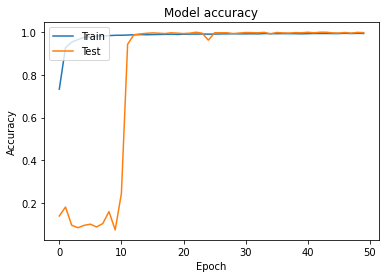

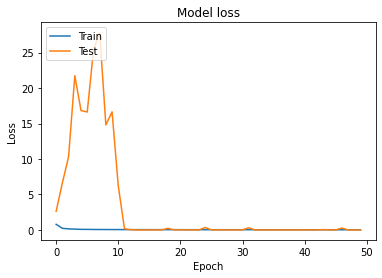

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


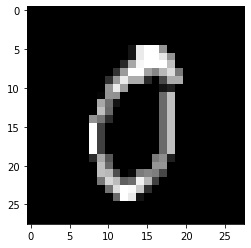

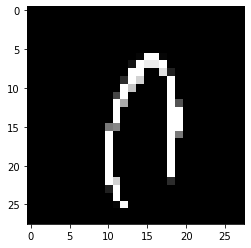

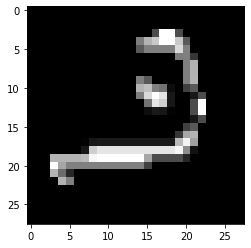

In [36]:
for i in range(1,4):
  pixels = train.iloc[i-1:i,1:]

# Make those columns into a array of 8-bits pixels
        # This array will be of 1D with length 784
        # The pixel intensity values are integers from 0 to 255
  pixels = np.array(pixels, dtype='uint8')

        # Reshape the array into 28 x 28 array (2-dimensional array)
  pixels = pixels.reshape((28, 28))

        # Plot

  plt.imshow(pixels, cmap='gray')
  plt.show()


In [38]:
for i in range(1,4):
  print(model.predict_classes(x[i-1:i,:]))

[0]
[1]
[2]
